In [1]:
import numpy as np
import pandas as pd
from copy import copy
import sys
sys.path.append('/home/ndsviriden/MinMax94/src/utils') 
from constants import data_directory, MmxColumns
from interpolation import interpolate_mmx, create_patterns
from converters import convert_raw_to_mmx
from preprocessing import get_clean_data
from loaders import load_mm94_stations, select_mm94_features
from geographical import find_nearest_wmo_station, add_solar_angles, add_coordinates, add_road_id
from sklearn.ensemble import IsolationForest
from score import get_labels
from score import calculate_precision, calculate_recall
import gc
from tqdm import tqdm_notebook
from functools import reduce

## Loading data

In [2]:
%%time
test_station_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 
                   511, 516, 1838, 1896]


train_station_id = [113, 115, 116, 118, 126, 150, 152, 200, 223, 228, 
                    239, 305, 308, 309, 401, 411, 432, 435, 454, 456, 
                    593, 628, 1831, 1899, 1911, 1921, 4007, 20323, 20717, 20743, 
                    20754, 20755, 20761, 20916, 20921]

raw = load_mm94_stations(train_station_id + test_station_id)
raw = select_mm94_features(raw, ['t_air', 't_road', 't_underroad', 'pressure', 'dampness'])

mmx_rwis = convert_raw_to_mmx(raw)
mmx_rwis_interpolated = interpolate_mmx(mmx_rwis)
data = create_patterns(mmx_rwis_interpolated)

data['data_solar_azimuth'], data['data_solar_altitude'] = add_solar_angles(data)
data['data_latitude'], data['data_longitude'] = add_coordinates(data)
data['data_road'] = add_road_id(data)
data = data.dropna(subset=('data_t_road', ))

del data[MmxColumns.ID_AIR_TEMPERATURE], data[MmxColumns.ID_UNDERGROUND_TEMPERATURE], \
    data[MmxColumns.ID_PRESSURE], data[MmxColumns.ID_HUMIDITY]

train = data[data['station_id'].isin(train_station_id)]
train = train.reset_index(drop=True)
train_clean = get_clean_data(train)

test = data[data['station_id'].isin(test_station_id)]
test = test.reset_index(drop=True)
test['label_true'] = get_labels(test, labels_type='true')

del data, raw, mmx_rwis, mmx_rwis_interpolated
gc.collect()

/home/ndsviriden/MinMax94/src/utils/geographical.py:65: RuntimeWarning: invalid value encountered in arccos
  solar_azimuth = np.arccos(cos_az) * np.sign(h_rad)


CPU times: user 1min 36s, sys: 10.6 s, total: 1min 46s
Wall time: 1min 48s


## Results

In [68]:
col_list = ['date_time_utc', 'station_id', 'id_t_road', 'target_t_road', 'decision_function', 
            'label_predict', 'label_true']

df_xgb_7 = pd.read_csv('/mnt/HARD/MinMax94/models/results/xgboost_7.csv', parse_dates=True,
                    usecols=col_list, dtype={'label_predict': int})

df_ridge_7 = pd.read_csv('/mnt/HARD/MinMax94/models/results/ridge_7.csv', parse_dates=True,
                    usecols=col_list, dtype={'label_predict': int})

df_ee = pd.read_csv('/mnt/HARD/MinMax94/models/results/elliptic_envelope.csv', parse_dates=True,
                  usecols=col_list, dtype={'label_predict': int})

df_lof = pd.read_csv('/mnt/HARD/MinMax94/models/results/local_outlier_factor.csv', parse_dates=True,
                      usecols=[col for col in col_list if col!='decision_function'], 
                      dtype={'label_predict': int})

df_iforest = pd.read_csv('/mnt/HARD/MinMax94/models/results/isolation_forest.csv', parse_dates=True,
                  usecols=col_list, dtype={'label_predict': int})

df_list = [(df_xgb_7, 'xgb_7'), (df_ridge_7, 'ridge_7'), (df_ee, 'ee'), (df_lof, 'lof'), (df_iforest, 'iforest')]

for df, name in df_list:
    df['label_predict_{0}'.format(name)] = df['label_predict']
    del df['label_predict']
    
    if name != 'lof':
        df['decision_function_{0}'.format(name)] = df['decision_function']
        del df['decision_function']
    
    elif name == 'lof':
        df['decision_function_{0}'.format(name)] = df['label_predict_lof']
        
col_list = ['date_time_utc', 'station_id', 'id_t_road', 'target_t_road', 'label_true']

        
df_test = pd.merge(df_xgb_7, df_ridge_7, on=merge_on)
df_test = pd.merge(df_test, df_ee, on=merge_on)
df_test = pd.merge(df_test, df_lof, on=merge_on)
#df_test = pd.merge(df_test, df_iforest, on=merge_on)

df_test['date_time_utc'] = pd.to_datetime(df_test['date_time_utc'])

In [96]:
df_test['label_predict'] = (1.0 * df_test['label_predict_xgb_7'] +
                            1.0 * df_test['label_predict_ridge_7'] +
                            0.5 * df_test['label_predict_ee'] +
                            0.5 * df_test['label_predict_lof']) >= 2 
                            #1.0 * df_test['label_predict_iforest']) >= 1

## Recall

In [99]:
predicted_anomalies_ids = set()
window = pd.Timedelta('5h')

#st_id = [114, 119, 302, 303, 442, 504, 511, 1838, 1896]
#st_id = [114, 117, 119, 302, 303, 442, 503, 504, 511, 1838, 1896]
#st_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]
for station in st_id:
    df = df_test[df_test['station_id']==station]
    predicted_anomalies = df[df['label_predict']==1]
    for anomaly in predicted_anomalies.iterrows():
        dt = anomaly[1]['date_time_utc']
        locality = df_test[(df_test['date_time_utc'] >= (dt - window)) & 
                       (df_test['date_time_utc'] <= (dt + window))]
        
        predicted_anomalies_ids.update(set(locality.index))

true_anomalies_ids = set(df_test[(df_test['label_true']==1) & (df_test['station_id'].isin(st_id))].index)

tp = set.intersection(true_anomalies_ids, predicted_anomalies_ids)
recall = len(tp) / len(true_anomalies_ids)
recall

0.5580304806565064

## Precision

In [100]:
true_anomalies_ids = set()
window = pd.Timedelta('5h')

#st_id = [114, 119, 302, 303, 442, 504, 511, 1838, 1896]
#st_id = [114, 117, 119, 302, 303, 442, 503, 504, 511, 1838, 1896]
#st_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]
for station in st_id:
    df = df_test[df_test['station_id']==station]
    true_anomalies = df[df['label_true']==1]
    for anomaly in true_anomalies.iterrows():
        dt = anomaly[1]['date_time_utc']
        locality = df_test[(df_test['date_time_utc'] >= (dt - window)) & 
                       (df_test['date_time_utc'] <= (dt + window))]
        
        true_anomalies_ids.update(set(locality.index))
        # print(list(locality.index))

predicted_anomalies_ids = set(df_test[((df_test['label_predict']==1) & (df_test['station_id'].isin(st_id)))].index)

tp = set.intersection(true_anomalies_ids, predicted_anomalies_ids)
precision = len(tp) / len(predicted_anomalies_ids)
precision

0.5904761904761905

## Cycle

In [83]:
predicted_anomalies_ids = set()
window = pd.Timedelta('4h')
station_list = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]

for station_id in station_list:
    st_id = [station_id]
    for station in st_id:
        df = df_test[df_test['station_id']==station]
        predicted_anomalies = df[df['label_predict']==1]
        for anomaly in predicted_anomalies.iterrows():
            dt = anomaly[1]['date_time_utc']
            locality = df_test[(df_test['date_time_utc'] >= (dt - window)) & 
                           (df_test['date_time_utc'] <= (dt + window))]

            predicted_anomalies_ids.update(set(locality.index))

    true_anomalies_ids = set(df_test[(df_test['label_true']==1) & (df_test['station_id'].isin(st_id))].index)

    tp = set.intersection(true_anomalies_ids, predicted_anomalies_ids)
    recall = len(tp) / len(true_anomalies_ids)

    true_anomalies_ids = set()
    window = pd.Timedelta('4h')

    for station in st_id:
        df = df_test[df_test['station_id']==station]
        true_anomalies = df[df['label_true']==1]
        for anomaly in true_anomalies.iterrows():
            dt = anomaly[1]['date_time_utc']
            locality = df_test[(df_test['date_time_utc'] >= (dt - window)) & 
                           (df_test['date_time_utc'] <= (dt + window))]

            true_anomalies_ids.update(set(locality.index))
            # print(list(locality.index))

    predicted_anomalies_ids = set(df_test[((df_test['label_predict']==1) & (df_test['station_id'].isin(st_id)))].index)

    tp = set.intersection(true_anomalies_ids, predicted_anomalies_ids)
    precision = len(tp) / len(predicted_anomalies_ids)
    
    print('{0} : R = {1:0.3f}, P = {2:0.3f}'.format(station_id, recall, precision))

114 : R = 0.611, P = 0.200
117 : R = 0.746, P = 0.445
119 : R = 0.848, P = 0.333
302 : R = 0.644, P = 0.338
303 : R = 0.628, P = 0.293
307 : R = 0.178, P = 0.851
393 : R = 0.039, P = 0.226
442 : R = 1.000, P = 0.329
503 : R = 0.137, P = 0.225
504 : R = 1.000, P = 0.351
511 : R = 1.000, P = 0.593
516 : R = 0.341, P = 0.515
1838 : R = 0.903, P = 0.177
1896 : R = 0.689, P = 0.735


## Plot

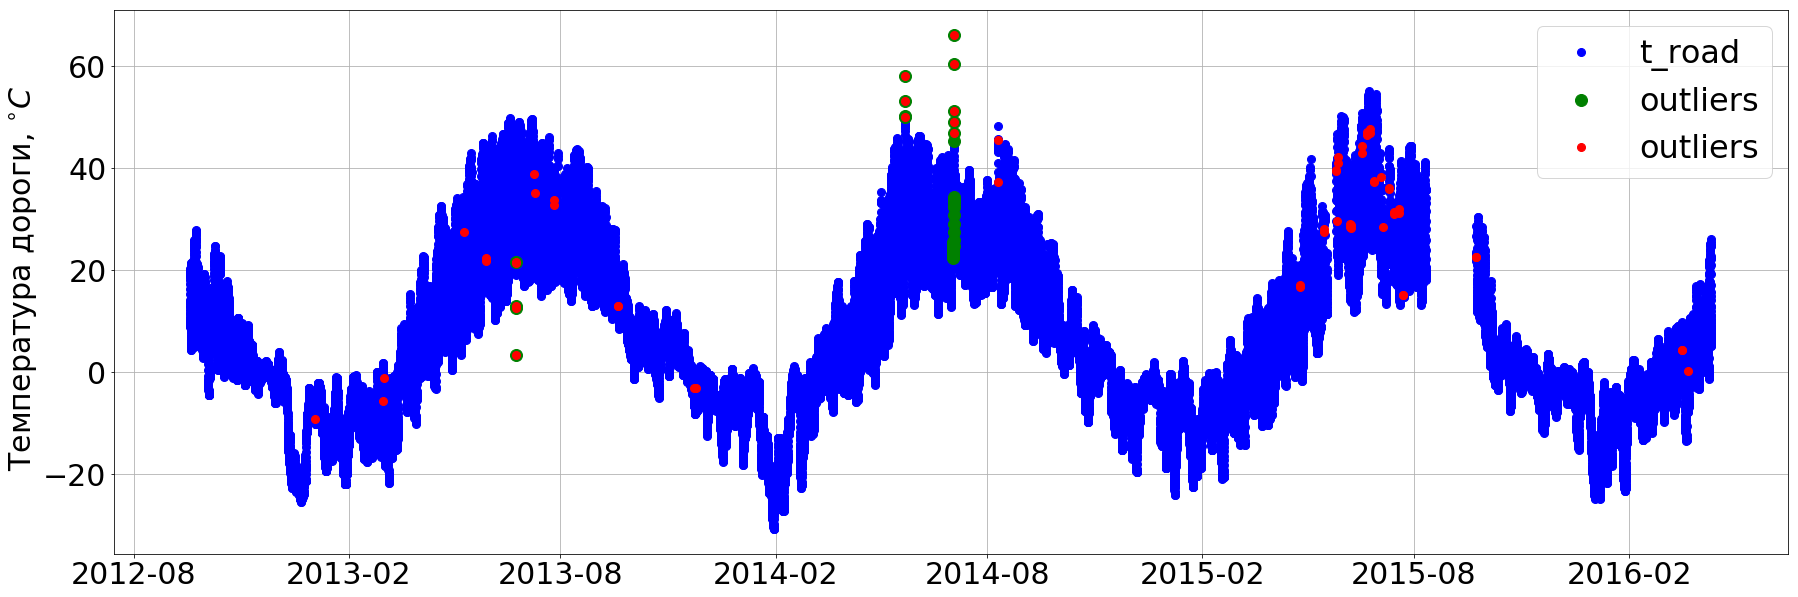

In [72]:
import matplotlib.pyplot as plt

#st_id = [114, 117, 119, 442, 504, 511, 1838, 1896]
#303, 307!!, 393!!, 503, 516
#test_station_id = [114, 119, 302, 303, 442, 504, 511, 516, 1838, 1896]
z = copy(df_test[df_test['station_id']==114].set_index('date_time_utc'))

start = pd.Timestamp(2012, 7, 1)
end = pd.Timestamp(2017, 7, 1)

to_plot = z[(z.index<=end) & (z.index>=start)]

plt.figure(figsize=(30, 10))

for elem in [True, False]:
    cond_predict = (to_plot['label_predict'] == 0) == elem
    cond_true = (to_plot['label_true'] == 0) == elem
    
    if elem:
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['target_t_road'], 'b',
                      linestyle='none', marker='o', markersize=8, label='t_road')
    else:
        
        plt.plot_date(to_plot[cond_true].index, to_plot[cond_true]['target_t_road'], 'g.',
                              linestyle='none', marker='o', label='outliers', markersize=12)
        
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['target_t_road'], 'r.',
                              linestyle='none', marker='o', label='outliers', markersize=8)

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' Температура дороги, $^{\circ}C$', fontsize=30)

plt.tick_params(labelsize=30)
plt.show()